In [ ]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:36<00:00, 30.2MB/s]
100% 1.06G/1.06G [00:36<00:00, 31.6MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,MaxPooling2D

In [ ]:
# Data Augmentation to increase training data size
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path to the training and validation directories
train_dir = '/content/train'  # Adjust the path accordingly
test_dir = '/content/test'    # Adjust the path accordingly

# Load and augment the images from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'  # Assuming binary classification (Cats and Dogs)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
# generators
train_data = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

val_data = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
## Normalize the dataset
def process(image,label):
      image = tf.cast(image/255., tf.float32)
      return image,label

train_data = train_data.map(process)
val_data = val_data.map(process)

In [ ]:
import pandas as pd
df = pd.DataFrame(train_data)

In [ ]:
df

### Create a CNN model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout

model = Sequential()

# Corrected 'input_shape'
model.add(Conv2D(32, (3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

model.add(Conv2D(64, (3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

model.add(Conv2D(128, (3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,epochs=10,validation_data = val_data)

Epoch 1/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.9906 - loss: 0.0300 - val_accuracy: 0.8262 - val_loss: 0.9795
Epoch 2/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.9884 - loss: 0.0350 - val_accuracy: 0.8206 - val_loss: 1.0713
Epoch 3/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.9904 - loss: 0.0285 - val_accuracy: 0.8252 - val_loss: 0.9948
Epoch 4/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.9900 - loss: 0.0251 - val_accuracy: 0.8356 - val_loss: 1.1719


In [ ]:
import matplotlib.pyplot as plt

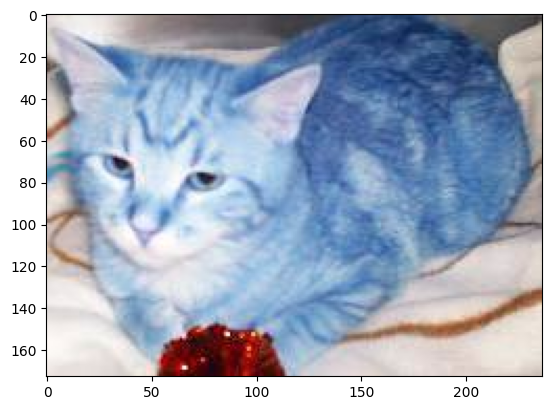

In [ ]:
import cv2
test_img = cv2.imread('/content/cat.42.jpg')
plt.imshow(test_img)

In [ ]:
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


array([[0.]], dtype=float32)

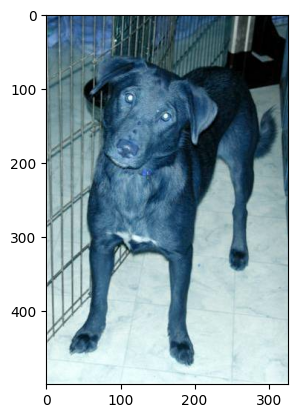

In [ ]:
import cv2
test_img = cv2.imread('/content/dog.1.jpg')
plt.imshow(test_img)

In [ ]:
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))


In [ ]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[1.]], dtype=float32)

In [ ]:
model.save('Cat_Dog_Classification.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2

# Data Augmentation to increase training data size
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Path to the training and validation directories
train_dir = '/content/train'  # Adjust the path accordingly
test_dir = '/content/test'    # Adjust the path accordingly

# Load and augment the images from the directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'  # Assuming binary classification (Cats and Dogs)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Building a CNN model with dropout to prevent overfitting
model = Sequential()

# Convolutional layers with Dropout and L2 Regularization
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

# Flatten the feature map
model.add(Flatten())

# Fully connected layers with Dropout to avoid overfitting
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout with a rate of 0.5 to prevent overfitting

# Output layer (binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


# Save the model
#model.save('cats_dogs_model.h5')


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 223ms/step - accuracy: 0.5526 - loss: 0.7601 - val_accuracy: 0.6314 - val_loss: 0.6507
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6080
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 221ms/step - accuracy: 0.6301 - loss: 0.6625 - val_accuracy: 0.7103 - val_loss: 0.5818
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 32us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7618
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 218ms/step - accuracy: 0.6630 - loss: 0.6265 - val_accuracy: 0.7103 - val_loss: 0.5740
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6234
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 219ms/step - accuracy: 0.6827 - loss: 0.6031 - val_accuracy: 0.7125 - val_loss: 0.5794
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accura

In [ ]:
# Train the model with data augmentation and dropout
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 220ms/step - accuracy: 0.7124 - loss: 0.5693 - val_accuracy: 0.7185 - val_loss: 0.5617
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.5362
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 220ms/step - accuracy: 0.7245 - loss: 0.5642 - val_accuracy: 0.7560 - val_loss: 0.5236
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.2163
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 220ms/step - accuracy: 0.7279 - loss: 0.5538 - val_accuracy: 0.7592 - val_loss: 0.5298


In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Print out the loss and accuracy
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7545 - loss: 0.5401
Test Loss: 0.529919445514679
Test Accuracy: 0.7592147588729858


In [ ]:
model.save('catdogclassifier.h5')